In [1]:
import os
import numpy as np


# return ksi, omegas, omega_d, freqs
def calFreqs(evals, beta, alpha):
    num_modes = len(evals)
    valid_map = np.zeros(num_modes)
    omegas = np.zeros(num_modes)
    omega_d = np.zeros(num_modes)
    ksi = np.zeros(num_modes)
    freqs = np.zeros(num_modes)

    for i in range(num_modes):
        if (evals[i] < 0):
            valid_map[i] = 0
            print('evals < 0 at ', i)
            continue

        omegas[i] = np.sqrt(evals[i])

        if (omegas[i] < 100 or omegas[i] > 2e5):
            print(f'omegas[{i}] = {omegas[i]} is out of 20hz 20000hz range')
            valid_map[i] = 0
            continue
        
        ksi[i] = (beta + alpha * evals[i]) / 2 / omegas[i]
        scale = 1 - ksi[i] * ksi[i]
        if (scale < 0 ):
            valid_map[i] = 0
            print('1 - ksi^2 < 0 at', i)
            continue

        omega_d[i] = omegas[i] * np.sqrt(scale)
        freqs[i] = 0.5 * omega_d[i] / np.pi
    return ksi, omegas, omega_d, freqs

# return mode_sample, samples
def genSound(ksi, omegas, omega_d, scales, fs, duration):
    num_modes = len(ksi)

    time_slot = np.arange(fs * duration) / fs

    mode_sample = np.zeros((num_modes, len(time_slot)))
    samples = np.zeros(len(time_slot))

    for i in range(num_modes):
        if(omega_d[i] != 0):
            amplitude = np.exp(time_slot * (-1) * ksi[i] * omegas[i]) * abs(scales[i]) / omega_d[i]
            mode_sample[i] = (np.sin(omega_d[i] * time_slot ) * amplitude).astype(np.float32)
            samples += mode_sample[i]
    return mode_sample, samples

def saveSound(filename, fs, samples):
    from scipy.io.wavfile import write
    tmp_samples = samples * 1e6
    write(filename, fs, tmp_samples)

In [2]:
###### Load #####
filename = 'T' + '104'
# obj_dir = '../DATA/obj/test'
gt_dir = '../DATA/eigen'
pred_dir = '../DATA/test_results'

# obj_file = os.path.join(obj_dir, filename+'.obj')
gt_file = os.path.join(gt_dir, filename, 'eigen.npz')
pred_file = os.path.join(pred_dir, filename+'.npy')

gt_read = np.load(gt_file)
gt = gt_read['evals']
evecs = gt_read['evecs']
pred = np.load(pred_file)
pred = pred * 1e9

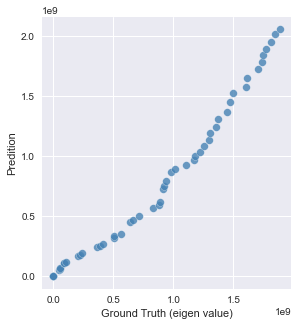

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.figure(figsize=(5,5))
# 绘图
plt.scatter(gt, # x轴数据为汽车速度
            pred, # y轴数据为汽车的刹车距离
            s = 60, # 设置点的大小 
            c = 'steelblue', # 设置点的颜色
            # marker = 's', # 设置点的形状
            alpha = 0.8, # 设置点的透明度
            linewidths = 0.3, # 设置散点边界的粗细、
            edgecolors = 'white' # 设置散点边界的颜色
            )

ax = plt.gca()
ax.set_aspect(1)
plt.xlabel('Ground Truth (eigen value)')
plt.ylabel('Predition')

plt.show()

In [4]:
###### Cal Freqs #####
pd_ksi, pd_omegas, pd_omega_d, pd_freqs = calFreqs(pred, beta=5.0, alpha=1e-7)

evals < 0 at  1
evals < 0 at  2


In [5]:
gt_ksi, gt_omegas, gt_omega_d, gt_freqs = calFreqs(gt, beta=5.0, alpha=1e-7)

evals < 0 at  0
omegas[1] = 0.00039233433785822814 is out of 20hz 20000hz range
omegas[2] = 0.0004882113058047235 is out of 20hz 20000hz range


In [6]:
###### Set Force #####
contact_pos = 695
contact_force = [0, -1, 0]
scales = np.zeros(50)
for dir in range(3):
    scales += contact_force[dir] * evecs[3*contact_pos + dir]
scales

array([ 4.16370791e-04,  8.12014880e-03,  8.34841875e-02,  5.38444559e-02,
       -4.64088292e-01,  2.40269735e-01,  6.33952606e-02, -3.06713984e-01,
        1.39311080e-01,  1.02629859e-03, -2.36149150e-02, -2.95632582e-02,
       -2.79399790e-02, -1.40385216e-01,  1.74695526e-01, -4.05092079e-02,
       -5.36415002e-01, -2.06414225e-01, -3.52945622e-04, -2.25857067e-01,
        2.49616598e-01,  1.65900295e-02,  3.84917756e-02,  1.51944461e-01,
        3.54731561e-02, -2.48028763e-02,  3.94392260e-02, -1.17424204e-01,
        8.94411347e-02, -1.55666568e-02, -1.18922752e-01, -1.18833122e-01,
        5.82852572e-03, -1.54060440e-02,  5.65963544e-02,  4.71856769e-02,
        2.47374904e-02, -6.41215402e-02,  3.24658081e-02, -1.19907645e-01,
        1.01433823e-01,  3.92856281e-02,  1.25192985e-02, -1.73666626e-01,
        2.28151798e-02, -7.69891723e-02, -7.67944988e-02,  8.41125769e-03,
       -9.62597757e-03,  5.96239225e-03])

In [7]:
###### Save as file #####
duration = 2
fs = 44100
gt_mode_sample, gt_sample = genSound(gt_ksi, gt_omegas, gt_omega_d, scales, fs, duration)
pd_mode_sample, pd_sample = genSound(pd_ksi, pd_omegas, pd_omega_d, scales, fs, duration)

saveSound(os.path.join('./EXP/', filename+'-p'+str(contact_pos)+'_gt.wav'), fs, gt_sample)
saveSound(os.path.join('./EXP/', filename+'-p'+str(contact_pos)+'_test.wav'), fs, gt_sample)